Some of the code parts are taken from the Roboflow notebook "how-to-estimate-vehicle-speed-with-computer-vision", which is excellent btw.

In [1]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

## Download Data

**NOTE:** In this notebook we will use one of the Supervision Assets videos. [Here](https://supervision.roboflow.com/assets) you can learn more about it.

In [2]:
#download_assets(VideoAssets.VEHICLES_2)

vehicles-2.mp4 asset download complete. 



'vehicles-2.mp4'

## Configuration

In [3]:
SOURCE_VIDEO_PATH = "vehicles-2_debug.mp4"
TARGET_VIDEO_PATH = "vehicles-2-result_debug.mp4"
CONFIDENCE_THRESHOLD = 0.2
IOU_THRESHOLD = 0.4
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [4]:
from IPython.display import HTML

HTML("""
    <video width="640" height="360" controls>
        <source src="vehicles-2_debug.mp4" type="video/mp4">
    </video>
""")

## Source and Target ROIs

![Source and Target ROIs](vehicles_2_sketch.png)

C:\Users\simon\AppData\Local\Temp\ipykernel_5980\2865307277.py:22: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)


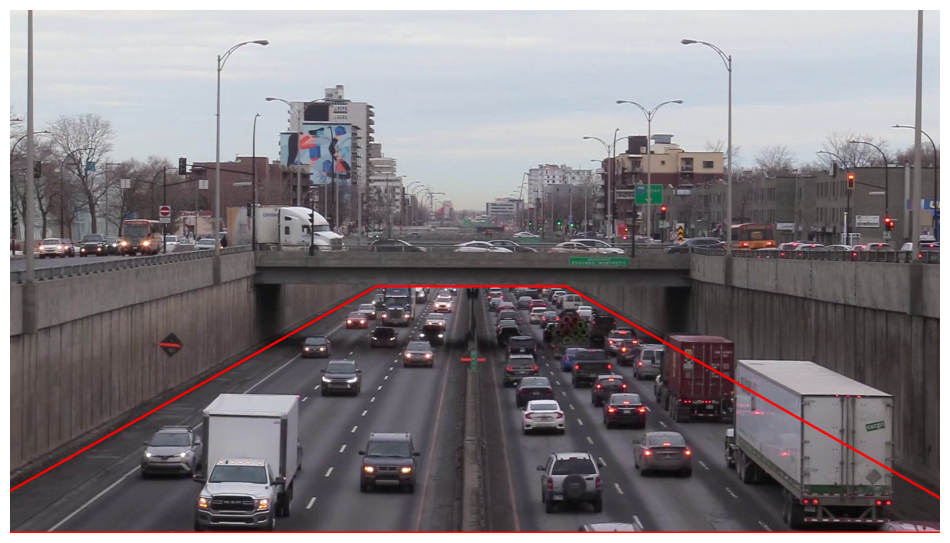

In [5]:
SOURCE = np.array([
    [676+80, 512+59],
    [1027+120, 512+59],
    [1931+115, 1079],
    [-155, 1079]
])
# had to fix some of the coordinates in post.

TARGET_WIDTH = 25
TARGET_HEIGHT = 210

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)
sv.plot_image(annotated_frame)

I used "https://www.freemaptools.com/measure-distance.htm", Google Maps and Gimp to get the measurements. The coordinates of the bridge are pretty much 45.48601291268425, -73.63443879214543. The length is a pretty rough estimate, which makes velocity estimations more inaccurate.

## Transform Perspective

In [6]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [7]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

## Process Video

In [8]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = sv.calculate_dynamic_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_dynamic_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 4,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# two separate variables, because I don't want to change the pattern recognition for the original
coordinates_x = defaultdict(lambda: deque(maxlen=int(np.floor(1.25*video_info.fps))))
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [x, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)
            coordinates_x[tracker_id].append(x)

        # format labels
        labels = []

        for tracker_id in detections.tracker_id:
            """
            The naive way to do this, would be by looking at the spatial gradient of the bounding boxes. 
            Let's assume the x-y axes are totally aligned with the street. Then, to some degree, 
            the spatial gradient in y-direction could give you a velocity estimate, which we're not interested in.
            However, the spatial gradient in x-direction tells you how much a car moves in their lane, or in-between.
            Introduce a threshold and voila! There is your lane change detector. At least in theory.

            Also, my speed estimates are sooo inaccurate, my estimations from maps are quite wrong, keep this in mind.
            """
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                if (len(coordinates[tracker_id]) > 10):
                    if np.abs(coordinates[tracker_id][-1] - coordinates[tracker_id][0]) > 70:
                        labels.append("!!Lane Change!!")
                    else:
                        labels.append("")
                else:
                    labels.append("")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6

                if (len(coordinates[tracker_id]) > 10):
                    if np.abs(coordinates[tracker_id][-1] - coordinates[tracker_id][0]) > 60:  # 60 works okay, 70 is too much
                        if speed < 245:  # yes, speed estimates are this wrong! And this solutions is hacky!
                            labels.append("!!Lane Change!!")
                        else:
                            labels.append(f"{int(speed)} km/h")
                    else:
                        labels.append("")
                else:
                    labels.append("")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [33:44<00:00,  1.59s/it]


# Summary

Surprise surprise, it does not work very well. The amount of false positives is quite high and the amount of correct detections is rather low. There are two main reasons for this: 
1) parameter overfitting to the debug sequence: I adapted the parameters such that the lane change of the green lorry in the debug sequence is detected, and not much else. This does not generalize well to the whole sequence.
2) the video itself: I wanted to keep the velocity estimation, and thus defined source and sink areas for the cars, which I think interferes to a degree with my original goal. The far bigger reason though is that there aren't that many lane changes in the video, the viewpoint of the video is suboptimal due to the bridge that splits the image in half (which makes tracking cars more difficult) and the number of cars is also quite high.

If I do this again, I would: 
1) choose a different video (less cars, sight of the whole highway, more clear lane changes),
2) split the lanes into incoming and passing traffic, then do a geometric transform for each. Then, you can properly work with gradients and don't have to do these strange parameter choices.